# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.certification.deep_z import PytorchDeepZ
from art.utils import load_mnist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

In [3]:
x_train = np.expand_dims(np.squeeze(x_train), axis=1)
x_test = np.expand_dims(np.squeeze(x_test), axis=1)
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

# Model

In [4]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=1)
        self.fc = nn.Linear(3200, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [5]:
model = MNISTModel()
model.to(device)

MNISTModel(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (fc): Linear(in_features=3200, out_features=10, bias=True)
  (relu): ReLU()
)

# Train

In [6]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [7]:
loss_fn = nn.CrossEntropyLoss()

In [8]:
def train_model(model, optimizer, loss_fn, x_data, y_data, batch_size=32, epochs=5):
    for epoch in range(epochs):
        x_data, y_data = shuffle(x_data, y_data)
        epoch_loss = []

        for start in range(0, len(x_data), batch_size):
            end = start + batch_size
            x_batch = torch.tensor(x_data[start:end]).float().to(device)
            y_batch = torch.tensor(y_data[start:end], dtype=torch.long).to(device)

            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())

        print(f"Epoch {epoch+1}, Loss: {np.mean(epoch_loss):.4f}")

    return model

In [9]:
model = train_model(model, optimizer, loss_fn, x_train, y_train)

Epoch 1, Loss: 0.4888
Epoch 2, Loss: 0.1805
Epoch 3, Loss: 0.1119
Epoch 4, Loss: 0.0827
Epoch 5, Loss: 0.0680


# Test

In [10]:
with torch.no_grad():
    safe_preds = model(torch.tensor(x_test).float().to(device))

In [11]:
safe_preds = np.argmax(safe_preds.cpu().detach().numpy(), axis=1)

In [12]:
print("Model Accuracy: {}%".format((np.sum(safe_preds == y_test) / len(y_test)) * 100))

Model Accuracy: 98.1%


# Deep Z

In [13]:
classifier = PytorchDeepZ(
    model=model,
    loss=nn.CrossEntropyLoss(),
    input_shape=(1, 28, 28),
    clip_values=(min_, max_),
    nb_classes=10,
    
)

Inferred reshape on op num 4


/home/alper/.local/lib/python3.10/site-packages/art/estimators/certification/deep_z/pytorch.py:242: UserWarning: 
This estimator does not support networks which have dense layers before convolutional. We currently infer a reshape when a neural network goes from convolutional layers to dense layers. If your use case does not fall into this pattern then consider directly building a certifier network with the custom layers found in art.estimators.certification.deepz.deep_z.py

  warnings.warn(


# Attack

In [14]:
pt_model = PyTorchClassifier(
    model=model,
    loss=nn.CrossEntropyLoss(),
    input_shape=(1, 28, 28),
    clip_values=(min_, max_),
    nb_classes=10,
    
)

In [15]:
attack = ProjectedGradientDescent(
    estimator=pt_model,
    eps=0.05,
    eps_step=0.001,
    max_iter=20,
    num_random_init=1
)

In [16]:
adv_test = attack.generate(x=x_test.astype('float32'))

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [17]:
classifier.model.set_forward_mode("concrete")

In [18]:
adv_preds = classifier.model.forward(torch.tensor(adv_test).float().to(device))

In [19]:
adv_preds = np.argmax(adv_preds.cpu().detach().numpy(), axis=1)

In [20]:
print("Adversarial Accuracy: {}%".format((np.sum(adv_preds == y_test) / len(y_test)) * 100))

Adversarial Accuracy: 96.71%


# Results

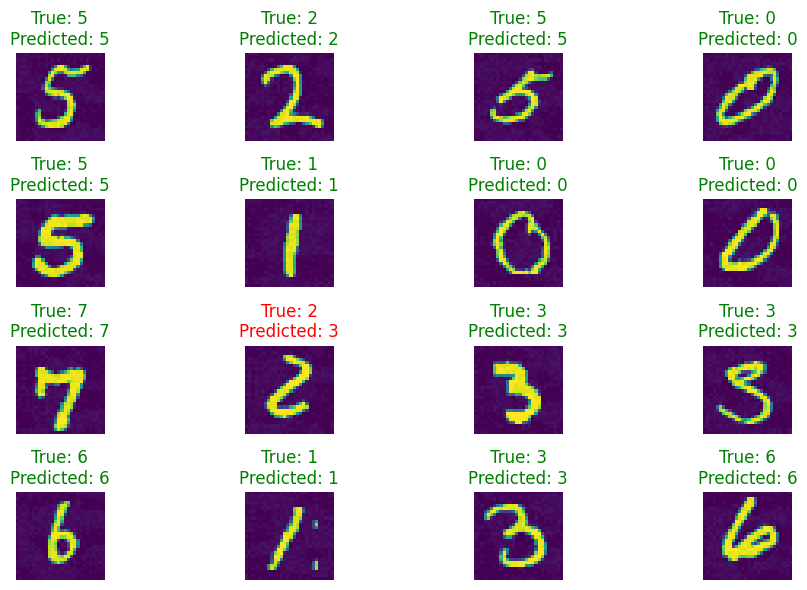

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(adv_test[random_index[i]].reshape(28, 28))
    ax.axis('off')

    if y_test[random_index[i]] == adv_preds[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {y_test[random_index[i]]}\nPredicted: {adv_preds[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()